In [6]:
# Import block
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color
from skimage.segmentation import mark_boundaries
from skimage.io import imread
import cv2

In [7]:
def display_image(image, caption=""):
   plt.figure(figsize=(8, 8))
   plt.imshow(image)
   plt.title(caption)
   plt.axis('off')
   plt.show()

In [8]:
def downscale_image(image, scale_factor):
    """
    Downscale image using OpenCV.
    
    Parameters:
    image: Input image array
    scale_factor: Factor to reduce image by (e.g., 2 means half size)
    
    Returns:
    Downscaled image
    """        
    new_width = int(image.shape[1] // scale_factor)
    new_height = int(image.shape[0] // scale_factor)
    
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

In [9]:
def load_and_downscale(image_path, scale_factor, rotate_90 = False):
    img = imread(image_path)  # Replace with your image path
    img = img.astype(float) / 255  # Convert to float between 0 and 1
    if rotate_90:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img_small = downscale_image(img, scale_factor)
    return img_small

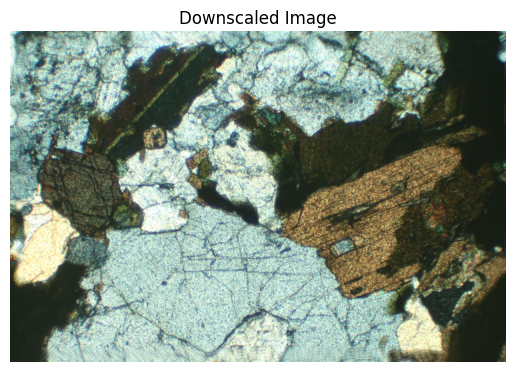

In [32]:
# Load and preprocess the image
img = load_and_downscale('./thin-sections/w15/w15_composite.jpg', 4)
plt.imshow(img)
plt.title('Downscaled Image')
plt.axis('off')
plt.show()

In [10]:
def visualize_segmentation(image, segments):
    """
    Visualize segmentation results with original boundaries and colored segments.
    
    Parameters:
    image: Original image (float array, values in [0,1])
    segments: Segmentation mask (integer array of labels)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original with boundaries
    ax1.imshow(mark_boundaries(image, segments, color=(1,1,0), mode='thin'))
    ax1.set_title(f'Segmentation Boundaries\n{len(np.unique(segments))} segments')
    ax1.axis('off')
    
    # Average color segments
    colored_segments = color.label2rgb(segments, image, kind='avg', bg_label=0)
    ax2.imshow(colored_segments)
    ax2.set_title('Average Color Segments')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
"""
SLIC params that work pretty well are shown below

n_segments is gonna vary between images, but it's good to go conservative (overestimate the amount of regions) for more precision.
Compactness works well with 10 and 20

segments = segmentation.slic(
    img, 
    n_segments=40,
    compactness=20,
    sigma=5,
    convert2lab=True,
    start_label=1,
)
"""

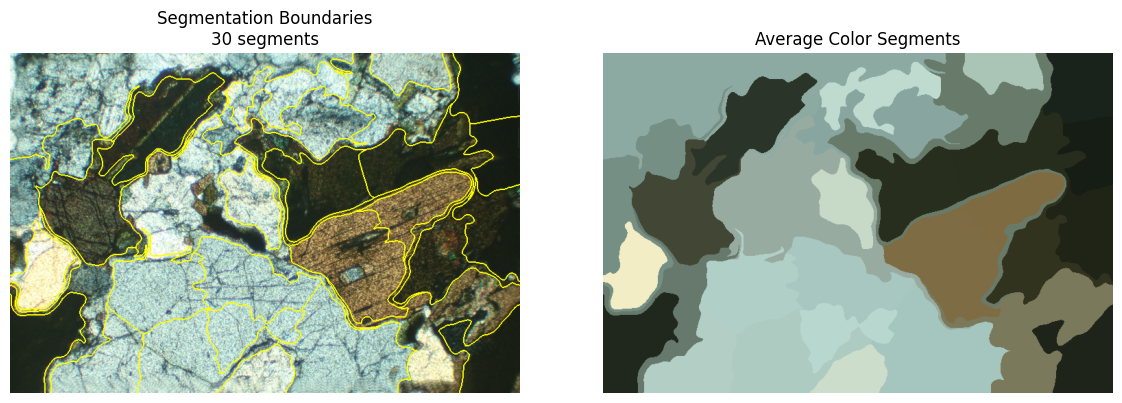

In [79]:
# Apply SLIC segmentation
segments = segmentation.slic(
    img, 
    n_segments=40,
    compactness=10,
    sigma=5,
    convert2lab=True,
    start_label=1,
)

visualize_segmentation(img, segments)

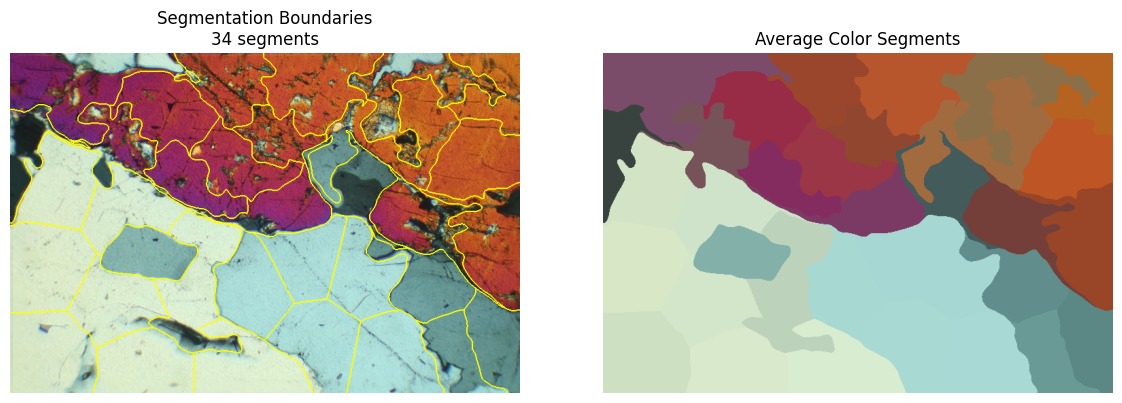

In [62]:
# Try with another image
# Apply SLIC segmentation
img2 = load_and_downscale(image_path='./thin-sections/8a/8a_composite.jpg',
                          scale_factor=4,
                          rotate_90=True)
segments = segmentation.slic(
    img2, 
    n_segments=40,
    compactness=20,
    sigma=5,
    convert2lab=True,
    start_label=1,
)

visualize_segmentation(img2, segments)

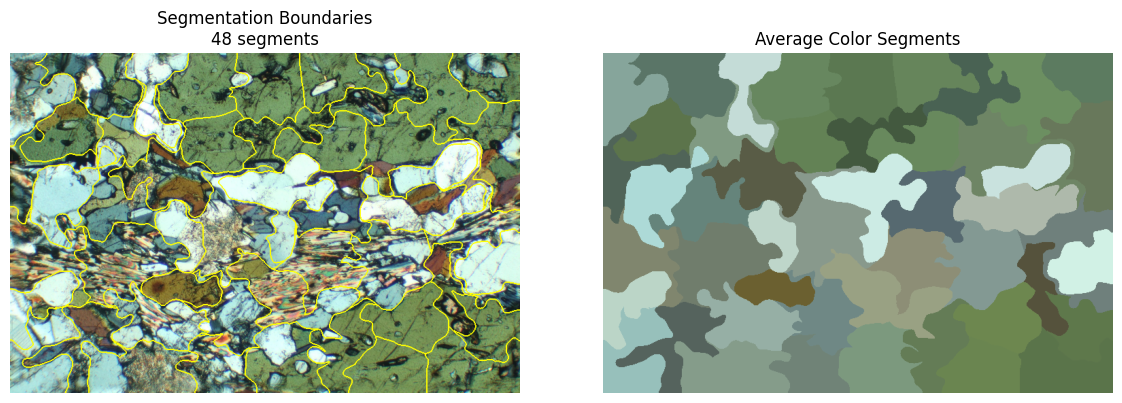

In [63]:
# Try with another image
# Apply SLIC segmentation
img3 = load_and_downscale(image_path='./thin-sections/9b_2/9b_2_composite.jpg',
                          scale_factor=4,
                          rotate_90=True)
segments = segmentation.slic(
    img3, 
    n_segments=50,
    compactness=20,
    sigma=5,
    convert2lab=True,
    start_label=1,
)

visualize_segmentation(img3, segments)

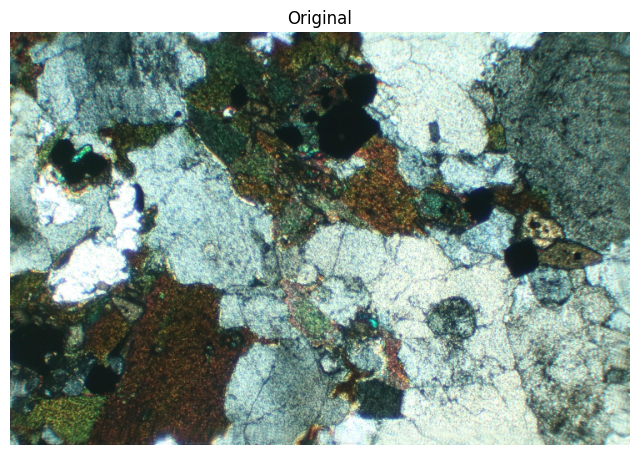

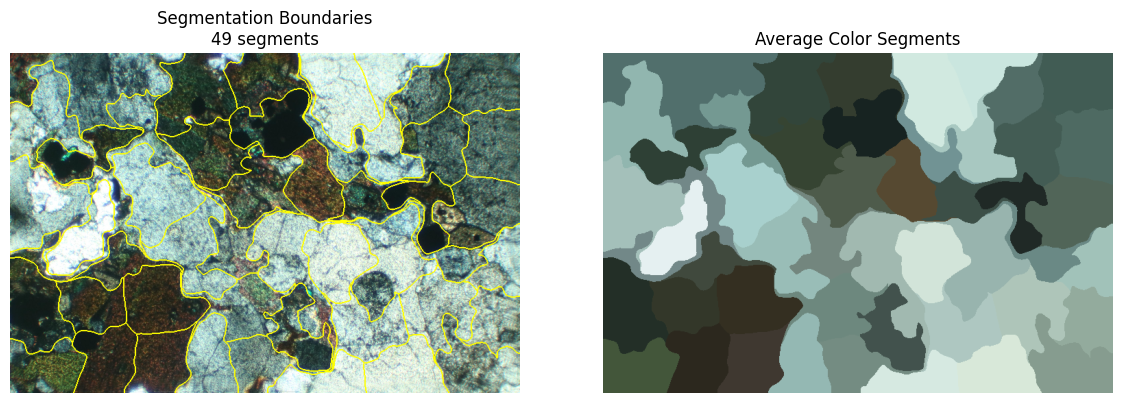

In [12]:
# Apply SLIC segmentation
img4 = load_and_downscale('./thin-sections/w13/w13_composite.jpg', 4)
segments = segmentation.slic(
    img4, 
    n_segments=50,
    compactness=20,
    sigma=5,
    convert2lab=True,
    start_label=1,
)
display_image(img4, 'Original')
visualize_segmentation(img4, segments)

Number of superpixels: 150


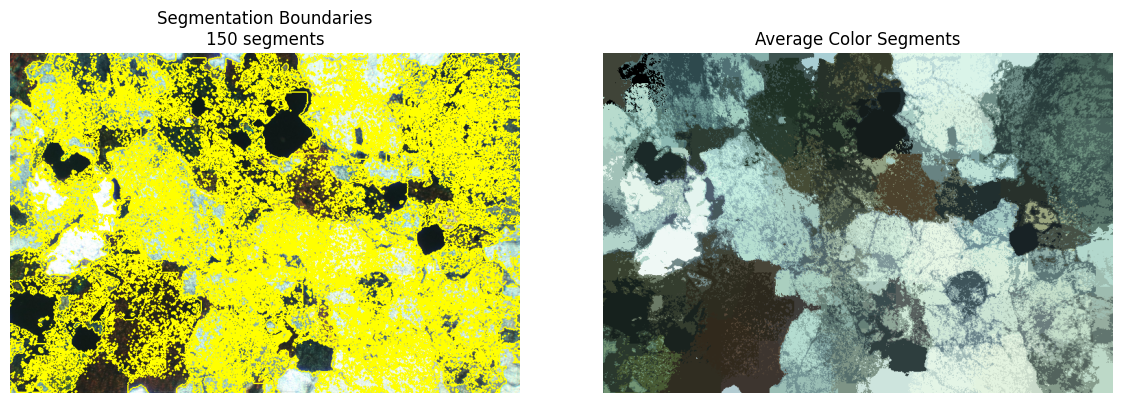

In [13]:
# OpenCV Superpixels

# Convert float RGB [0-1] to uint8 [0-255]
img_uint8 = (img4 * 255).astype(np.uint8)

# Create SLIC object
slic = cv2.ximgproc.createSuperpixelSLIC(
    image=img_uint8,
    algorithm=cv2.ximgproc.SLIC,  # or cv2.ximgproc.SLICO
    region_size=50,  # Rough size of superpixel regions
    ruler=20.0  # Similar to compactness parameter
)

# Compute superpixels
slic.iterate(10)  # Number of iterations

# Get labels
segments = slic.getLabels()

# If you want to know number of superpixels actually generated:
num_superpixels = slic.getNumberOfSuperpixels()
print(f"Number of superpixels: {num_superpixels}")

# Your existing visualization
visualize_segmentation(img4, segments)

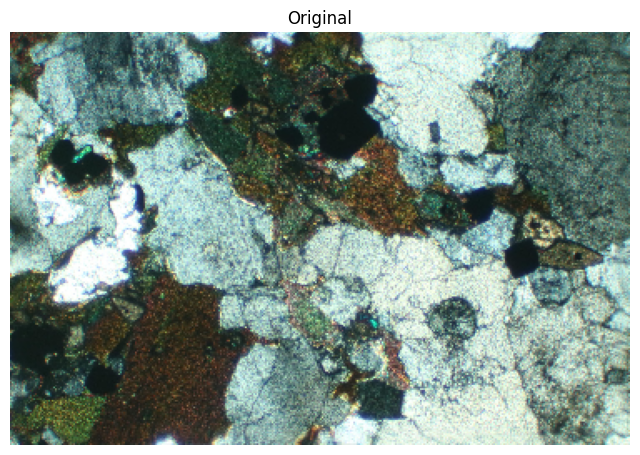

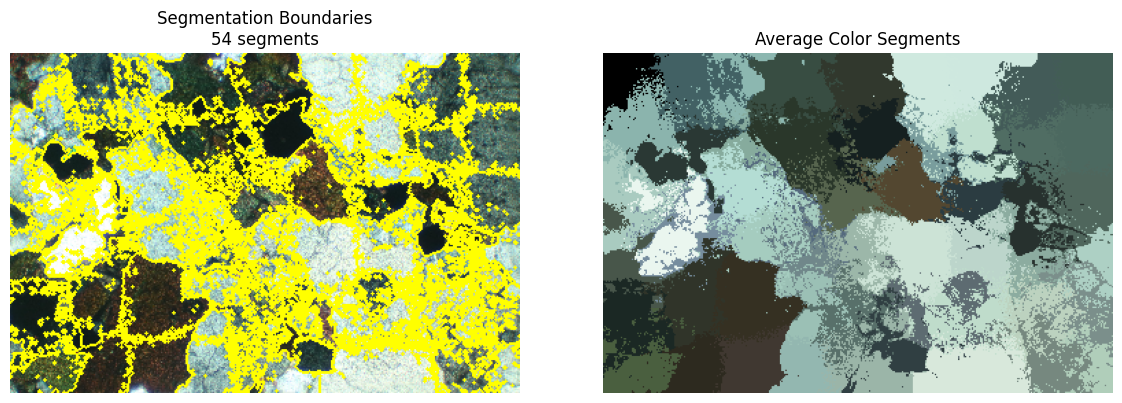

In [16]:
# Apply SLIC segmentation
img4 = load_and_downscale('./thin-sections/w13/w13_composite.jpg', 8)
display_image(img4, 'Original')
segments = slic_superpixels(
    img4, 
    n_segments=50,
    compactness=20,
)
visualize_segmentation(img4, segments)

In [15]:
import numpy as np
from skimage import color
from sklearn.preprocessing import normalize

def slic_superpixels(image, n_segments, compactness=10.0, max_iter=10):
    """
    Implements SLIC (Simple Linear Iterative Clustering) superpixel algorithm.
    
    Args:
        image: numpy array of shape (height, width, 3), values in range [0, 1]
        n_segments: desired number of superpixels
        compactness: factor that controls superpixel compactness (default: 10.0)
        max_iter: maximum number of iterations (default: 10)
        
    Returns:
        labels: numpy array of shape (height, width) containing superpixel labels
    """
    height, width = image.shape[:2]
    num_pixels = height * width
    
    # Convert to LAB color space
    lab_image = color.rgb2lab(image)
    
    # Initialize cluster centers on a regular grid
    grid_step = int(np.sqrt(num_pixels / n_segments))
    x_range = np.arange(grid_step//2, width, grid_step)
    y_range = np.arange(grid_step//2, height, grid_step)
    
    centers = []
    for y in y_range:
        for x in x_range:
            if y >= height or x >= width:
                continue
            center = np.array([y, x, *lab_image[int(y), int(x)]])
            centers.append(center)
    centers = np.array(centers)
    
    # Initialize labels and distances
    labels = -1 * np.ones((height, width), dtype=np.int32)
    distances = np.inf * np.ones((height, width))
    
    # Main loop
    for _ in range(max_iter):
        for i, center in enumerate(centers):
            # Get search region boundaries
            y_min = max(0, int(center[0] - grid_step))
            y_max = min(height, int(center[0] + grid_step))
            x_min = max(0, int(center[1] - grid_step))
            x_max = min(width, int(center[1] + grid_step))
            
            # Extract region
            region_lab = lab_image[y_min:y_max, x_min:x_max]
            
            # Spatial distance (L2 norm)
            y_coords, x_coords = np.mgrid[y_min:y_max, x_min:x_max]
            spatial_dist = np.sqrt(
                (y_coords - center[0]) ** 2 + 
                (x_coords - center[1]) ** 2
            )
            
            # Color distance (L2 norm in LAB space)
            color_dist = np.sqrt(
                (region_lab[:, :, 0] - center[2]) ** 2 +
                (region_lab[:, :, 1] - center[3]) ** 2 +
                (region_lab[:, :, 2] - center[4]) ** 2
            )
            dist = color_dist + (compactness/grid_step) * spatial_dist
            
            # Update labels and distances
            mask = dist < distances[y_min:y_max, x_min:x_max]
            distances[y_min:y_max, x_min:x_max][mask] = dist[mask]
            labels[y_min:y_max, x_min:x_max][mask] = i
            
        # Update centers
        new_centers = np.zeros_like(centers)
        for i in range(len(centers)):
            mask = labels == i
            if mask.any():
                new_centers[i, 0:2] = np.mean(np.vstack(np.where(mask)), axis=1)
                new_centers[i, 2:] = np.mean(lab_image[mask], axis=0)
            else:
                new_centers[i] = centers[i]
        
        # Check convergence
        center_shift = np.sum(np.sqrt(np.sum((centers - new_centers) ** 2, axis=1)))
        centers = new_centers
        
        if center_shift < grid_step * 0.01:  # Convergence threshold
            break
    
    # Enforce connectivity
    labels = enforce_connectivity(labels)
    
    return labels

from scipy import ndimage  # for connected components labeling

def enforce_connectivity(labels):
    """
    Enforce connectivity of superpixels by merging small disconnected segments.
    Uses a fast two-pass method as described in the original SLIC paper.
    
    Args:
        labels: numpy array of superpixel labels
    Returns:
        labels: numpy array of superpixel labels with small segments merged
    """
    # First pass: find disjoint segments
    segment_mask = (labels >= 0)  # Ignore background (-1) if any
    connected_labels, num_segments = ndimage.label(segment_mask)
    
    # Get size of each segment
    segment_sizes = np.bincount(connected_labels.ravel())
    
    # Compute minimum size threshold (mentioned as 25 pixels in paper)
    min_size = 25
    
    # Second pass: merge small segments
    small_segments = np.where(segment_sizes < min_size)[0]
    
    if len(small_segments) == 0:
        return labels
        
    # For each small segment
    for small_seg in small_segments:
        if small_seg == 0:  # Skip background
            continue
            
        # Get mask of current small segment
        small_mask = connected_labels == small_seg
        
        if not np.any(small_mask):  # Skip if segment has already been merged
            continue
            
        # Find neighbors (dilate mask and subtract original)
        kernel = np.ones((3,3), bool)
        neighbors_mask = ndimage.binary_dilation(small_mask, kernel) & ~small_mask
        
        if not np.any(neighbors_mask):
            continue
            
        # Get unique SLIC labels of neighbors
        neighbor_labels = labels[neighbors_mask]
        unique_neighbors = np.unique(neighbor_labels)
        
        # Find the most frequent neighbor label
        best_label = unique_neighbors[
            np.argmax([np.sum(neighbor_labels == label) for label in unique_neighbors])
        ]
        
        # Merge with largest neighbor
        labels[small_mask] = best_label
        
    return labels